In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import re
from symspellpy import SymSpell, Verbosity
import numpy as np
import gensim.downloader as api

In [2]:
df_original = pd.read_csv("data/noon_perfumes_dataset.csv", index_col=0)
df = df_original.copy(deep=True)

### Pre-proc

In [3]:
#CROP IRRELEVANT COLUMNS
irrelevant_cols = ['item_rating', 'noon','seller_rating','num_seller_ratings','']
relevant_cols = ['brand','name','department']
df_cropped = df.drop_duplicates(subset=relevant_cols)

In [4]:
#CONVERT PRICE TO REAL MONEYS
df.old_price = df_original.old_price*0.24
df.new_price = df_original.new_price*0.24

In [5]:
#REMOVE THE CHILD
df.drop(index=df[df.department == 'Kids Unisex'].index, inplace=True)

In [6]:
#REMOVE THE OIL
df.drop(index=df[df.concentration == 'Oil'].index, inplace=True)

In [7]:
#REMOVE THE PDT
df.drop(index=df[df.concentration == 'PDT'].index, inplace=True)

In [8]:
perf_names, counts = np.unique(df.name, return_counts=True)
counts_sorted = np.argsort(-counts)

In [9]:
perf_names[counts_sorted], counts[counts_sorted]

(array(['Eros', 'Roses Vanille', 'Homme', 'Pour Homme', 'Uomo',
        'Encre Noire', 'Essence Pure', 'Marciano', 'Passenger', 'Beauty',
        'Paradiso Assoluto', 'London', 'Sauvage', 'Pour Femme',
        'Cool Water', 'Crystal Noir', 'CK One', 'One Shock', 'Legend',
        'The One', 'Sacrifice', 'Dylan Blue', 'Just Cavalli',
        'Petits Et Mamans', 'Burberry Body', 'Private Collection',
        'Narciso Rodriguez', 'Guilty Absolute', '212 Sexy', 'Good Girl',
        'Stronger With You', 'The Scent', 'Scandal', 'Bleu De Chanel',
        "L'Homme", 'Florence', 'Dare', 'Love Story', 'Euphoria', 'Desire',
        'My Burberry', 'Emblem', 'Shuhrah', 'Happy Spirit', 'Escape',
        'The Game', 'Declaration', 'Scuderia Red', 'Musk Cologne Sp',
        'Hot', 'Hugo', 'Boss The Scent', 'Dupont', 'Essential', 'Quatre',
        'Cabotine', 'Eternity', 'Fantasy', 'Femme', 'First',
        'Rouat Al Oud', 'Floral', 'Sheikh Al Shuyukh', 'Explorer',
        'Classic Black', 'Furiosa', '

In [10]:
test = df.drop_duplicates()

In [11]:
old_prices = df.old_price
new_prices = df.new_price
ml = df.ml

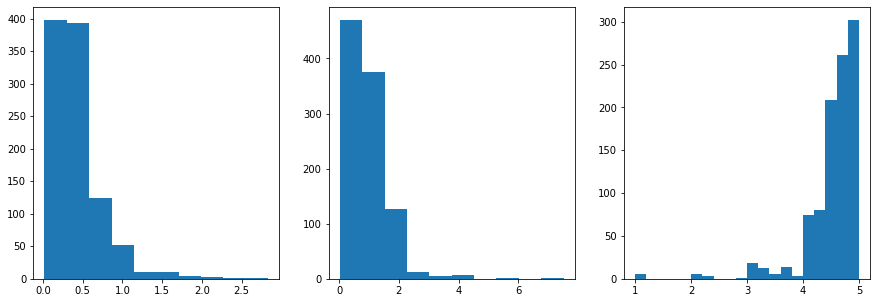

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(x=new_prices/ml); ax[1].hist(x=old_prices/ml); ax[2].hist(df.item_rating, bins=20);

In [13]:
notes = df[['base_note', 'middle_note']].values

In [14]:
def text_clean(text_array):
    text_list = []
    for text_pair in text_array:
        text = ", ".join(text_pair).lower().replace(" and", ",") #join base_note and middle_note strings, lowercase everything and replace "and" with a comma
        text = re.sub(r"\b\s\b|\b\,\b", ", ", text)
        text = re.sub(r"\B\,|of |the |-", "", text)
        text_list.append(text)
        #text_list.append(text.split(", ")) #split at commas (this way we preserve notes desribed by > 1 word)
    return text_list

In [15]:
sent_dic = text_clean(notes)
sym_spell = SymSpell(max_dictionary_edit_distance=2, count_threshold=5)
sym_spell.create_dictionary(sent_dic)
#suggestions = sym_spell.lookup_compound(", ".join(sent_dic).replace(",", ""), max_edit_distance=2)

True

In [16]:
sent_dic_autocorrected = []
for sent in sent_dic:
    s = str()
    for word in sent.split(", "):
        suggestions = sym_spell.lookup(word, verbosity=Verbosity.ALL, max_edit_distance=2)
        if suggestions:
            word = suggestions[np.argmax([sug.count for sug in suggestions])].term
        s += word+" "
    sent_dic_autocorrected.append(s)


In [17]:
wv = api.load('glove-wiki-gigaword-300')


In [18]:
sents_vectorized = []
for sent in sent_dic_autocorrected:
    sent_vectorized = []
    word_count = 0
    for word in sent.split():
        if word in wv:
            if word_count == 0:
                vector = wv.get_vector(word)
            else:
                np.add(vector, wv.get_vector(word))
            word_count += 1
        else:
            continue
    sents_vectorized.append(vector/(word_count+1))
    

In [45]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE                  
from sklearn.manifold import MDS
embedding = MDS(n_components=2)

pca = PCA(n_components=2)

In [49]:
scaled_sents = pca.fit_transform(sents_vectorized)
mds_sents = embedding.fit_transform(np.array(sents_vectorized).astype(np.float64))


In [43]:
from sklearn.preprocessing import LabelEncoder
mlb = LabelEncoder()
scent_labels = mlb.fit_transform(df.scents)

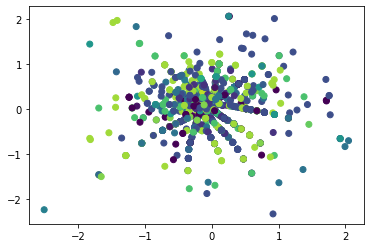

In [50]:
plt.scatter(mds_sents[:,0], mds_sents[:,1], c=scent_labels)

In [29]:
df.head()

,brand,name,old_price,new_price,ml,concentration,department,scents,base_note,middle_note,item_rating,seller,seller_rating,num_seller_ratings
0,PACO RABANNE,1 Million Lucky,94.8,58.692,100,EDT,Men,Woody,"Oakmoss, Patchouli and Vetiver","Hazelnut, Jasmine, Cashmir Wood, Cedar and Honey",5.0,noon,4.2,98.1K
1,Roberto Cavalli,Paradiso Assoluto,99.6,25.908,50,EDP,Women,Floral,"Vanilla, Sandalwood And Patchouli",Wild Jasmine and Red Lily,4.8,noon,4.2,98.1K
2,S.T.Dupont,Royal Amber,63.6,44.856,100,EDP,Unisex,Arabian,"Lemon, Mint and Wood Moss",Sandalwood and Cedar,5.0,noon,4.2,98.1K
3,GUESS,Seductive Blue,69.6,24.768,100,EDT,Men,Spicy,"Cashmere Wood, Moss And Rippled Sand Accord",Blue Coral Aquaspace Accord And Geranium,3.0,noon,4.2,98.1K
4,Roberto Cavalli,Uomo,62.4,22.788,50,EDP,Women,Arabian,"Vanille, Benzoin, Tonka Bean",African Orange Flower,4.8,noon,4.2,98.1K
